<a href="https://colab.research.google.com/github/emmab-collab/PyTorch/blob/main/Digestive_Biopsy_Classification_w_PyTorch_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install medmnist

In [6]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as tt
from torch.utils.data.dataloader import DataLoader

from medmnist import INFO, PathMNIST

# **1. Preparing the data**

## **1. Data transformation (normalization and augmentation)**

On va prendre exceptionnellement tout le trainset pour train et le testset pour val

``RandomCrop`` :
- pad each image by 4 pixels
- take a random crop of size 28x28
- mode:'reflect' ca remplit le vide avec le miroir de l'image

``RandomHorizontalFlip`` : flip the image horizontally with a 50% probability

In [7]:
train_tfms=tt.Compose([tt.RandomCrop(28,padding=4,padding_mode='reflect'),
                      tt.RandomHorizontalFlip(), #avec une proba de 50%
                      tt.ToTensor(),
                      tt.Normalize((0.5,), (0.5,))])
val_tfms=tt.Compose([tt.ToTensor(),tt.Normalize((0.5,), (0.5,))])

In [8]:
train_ds = PathMNIST(split='train', download=True, transform=train_tfms)
val_ds = PathMNIST(split='val', download=True, transform=val_tfms)

In [9]:
img,label=train_ds[0]
print(img.shape,label)
img

torch.Size([3, 28, 28]) [0]


tensor([[[0.7255, 0.7176, 0.7255,  ..., 0.6000, 0.6000, 0.6000],
         [0.7255, 0.7176, 0.7255,  ..., 0.7098, 0.6157, 0.5608],
         [0.7333, 0.7255, 0.7176,  ..., 0.7412, 0.7333, 0.7333],
         ...,
         [0.7176, 0.5686, 0.4980,  ..., 0.7412, 0.7333, 0.7412],
         [0.7255, 0.7255, 0.7255,  ..., 0.7412, 0.7333, 0.7176],
         [0.7098, 0.7333, 0.7020,  ..., 0.7490, 0.7490, 0.7412]],

        [[0.6157, 0.6078, 0.6235,  ..., 0.3490, 0.4039, 0.4588],
         [0.6235, 0.6157, 0.6235,  ..., 0.5765, 0.4275, 0.3961],
         [0.6392, 0.6235, 0.6235,  ..., 0.6392, 0.6392, 0.6392],
         ...,
         [0.6078, 0.4039, 0.3176,  ..., 0.6392, 0.6392, 0.6392],
         [0.6235, 0.6157, 0.6157,  ..., 0.6471, 0.6314, 0.6235],
         [0.6157, 0.6314, 0.5765,  ..., 0.6471, 0.6471, 0.6392]],

        [[0.7725, 0.7647, 0.7725,  ..., 0.5843, 0.6157, 0.6471],
         [0.7804, 0.7725, 0.7725,  ..., 0.7412, 0.6314, 0.5922],
         [0.7882, 0.7804, 0.7804,  ..., 0.7804, 0.7882, 0.

In [10]:
len(train_ds)

89996

In [11]:
repartition=torch.bincount(torch.tensor(train_ds.labels.squeeze())).tolist()

In [12]:
repartition/np.sum(repartition)

array([0.10407129, 0.10566025, 0.11511623, 0.1155718 , 0.08895951,
       0.13536157, 0.08762612, 0.1044602 , 0.14317303])

In [13]:
train_ds

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K

## **2. Create dataloaders**

``num_workers`` : can be used to leverage multiple CPU cores and load images in parallel.

``pin_memory`` : avoid repeated memory allocation and dealllocation by using the same portion of memory (RAM) for loading each batch of data.

``suffle=True`` : when an epoch starts, it shuffles the train_dl and then creates batches. At the end of one epoch, it shuffles them again and then new batches come. It helps the model generalize by seing more variety.

In [14]:
from torch.utils.data import DataLoader

batch_size=256
train_dl=DataLoader(train_ds,batch_size,shuffle=True,
                   num_workers=8,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size,shuffle=False,
                 num_workers=8,pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# **2. Visualiser les images**

On le fait juste pour le premier batch et les 100 premières images du batch.

Les images sont bizarres à cause de toutes les transformations faites.
Les couleurs sont changées à cause de la normalisation.

In [15]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(16,16))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(images[:100],10).permute(1,2,0))
        break

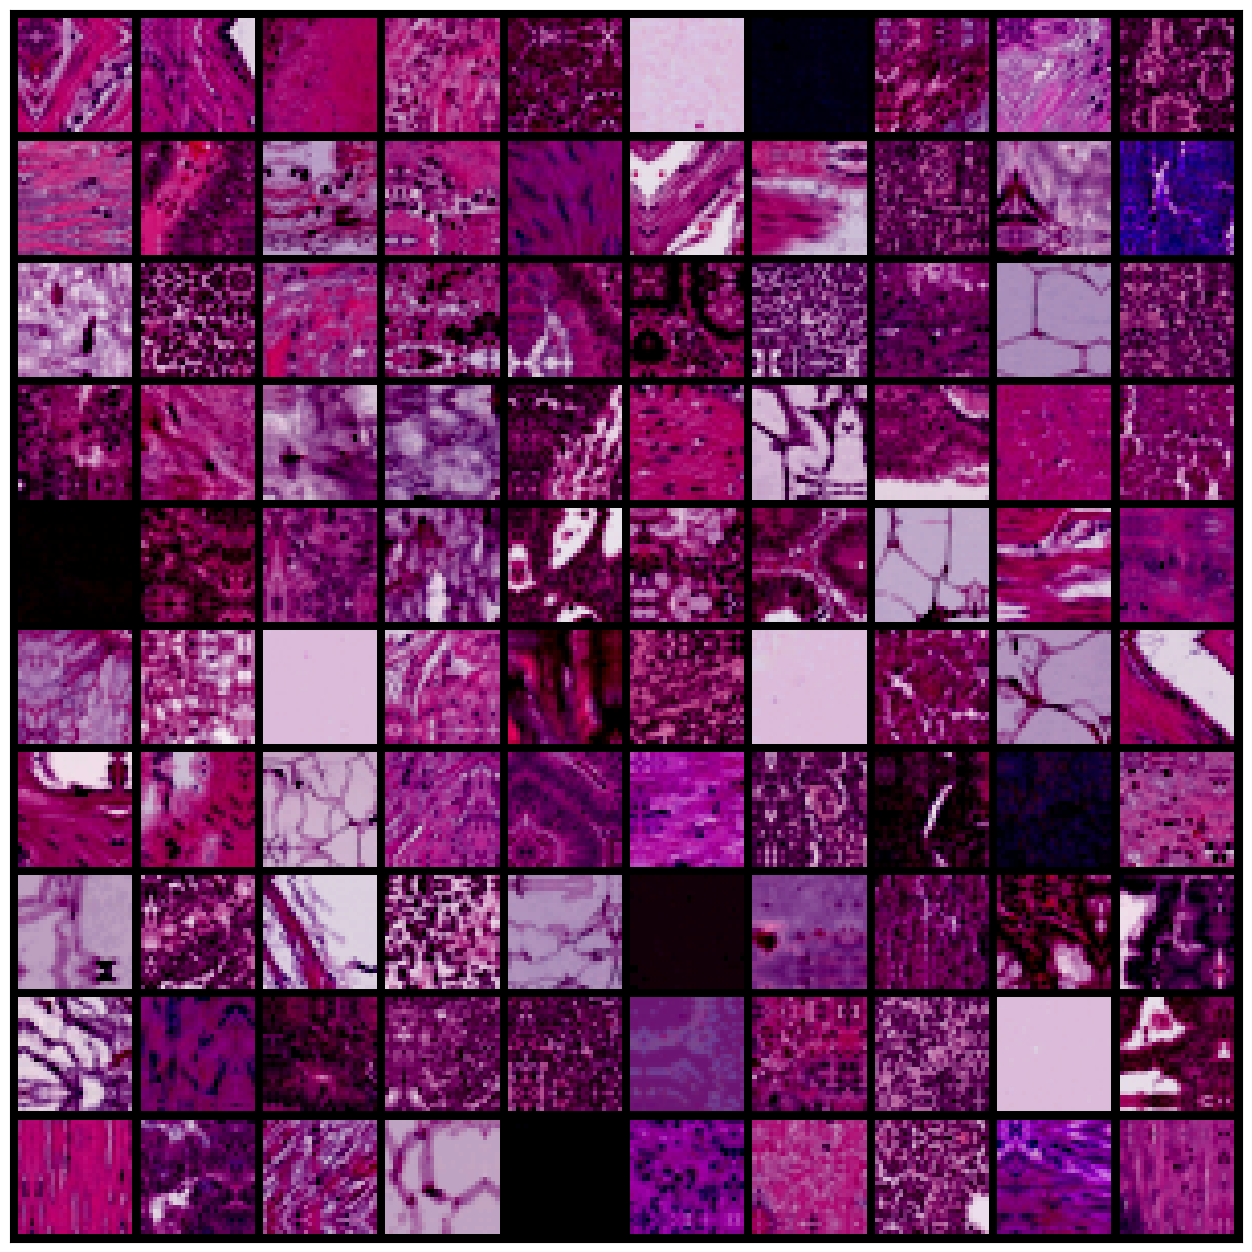

In [16]:
show_batch(train_dl)

In [17]:
data_flag = 'pathmnist'
info = INFO[data_flag]
labels = info['label']
print(f"Les labels: \n{labels}\n")

Les labels: 
{'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}



In [18]:
labels['0']

'adipose'

In [19]:
num_classes = len(labels)
print(f"Nombre de classes : {num_classes}")

Nombre de classes : 9


# **3. Defining the Model (WideResNet22)**

**22** : 22 convolutional layers

**residual blocs** : adds the original input ack to the output feature map obtained by passing the input through one or more convolutional layers.

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu1=nn.ReLU()
        self.conv2=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()

    def forward(self,x):
        out=self.conv1(x)
        out=self.relu1(out)
        out=self.conv2(out)
        return self.relu2(out + x)

In [22]:
simple_resnet=SimpleResidualBlock()

for images,labels in train_dl:
    out=simple_resnet(images)
    print(out.shape)
    break

torch.Size([256, 3, 28, 28])


In [23]:
def conv_2d(ni,nf,stride=1,ks=3):
    return nn.Conv2d(in_channels=ni,out_channels=nf,
                    kernel_size=ks,stride=stride,
                    padding=ks//2,bias=False)

def bn_relu_conv(ni,nf):
    return nn.Sequential(nn.BatchNorm2d(ni),
                       nn.ReLU(inplace=True),
                       conv_2d(ni,nf))

class ResidualBlock(nn.Module):
    def __init__(self,ni,nf,stride=1):
        super().__init__()
        self.bn=nn.BatchNorm2d(ni)
        self.conv1=conv_2d(ni,nf,stride)
        self.conv2=bn_relu_conv(nf,nf)
        self.shortcut=lambda x: x #c'est une fonction qui retourne l'input
        if ni!=nf:
            self.shortcut=conv_2d(ni,nf,stride,1)

    def forward(self,x):
        x=F.relu(self.bn(x),inplace=True)
        r=self.shortcut(x)
        x=self.conv1(x)
        x=self.conv2(x)*0.2 #scaling factor (ca marche mieux)
        return x.add_(r)

In [24]:
def make_group(N,ni,nf,stride):
    start=ResidualBlock(ni,nf,stride)
    rest=[ResidualBlock(nf,nf)for j in range(1,N)]
    return [start]+rest

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return x.reshape(x.size(0),-1)

class WideResNet(nn.Module):
    def __init__(self,n_groups,N,n_classes,k=1,n_start=16):
        super().__init__()
        #increase channels to n_start using conv layer
        layers=[conv_2d(3,n_start)]
        n_channels=[n_start]

        #add groups of BasicBlock(increase channels and downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride=2 if i>0 else 1
            layers += make_group(N,n_channels[i],
                                n_channels[i+1],stride)

        #Pool, flatten and and linear layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]),
                  nn.ReLU(inplace=True),
                  nn.AdaptiveAvgPool2d(1),
                  Flatten(),
                  nn.Linear(n_channels[3],n_classes)]

        self.features=nn.Sequential(*layers)

    def forward(self,x):
        return self.features(x)

def wrn_22():
    return WideResNet(n_groups=3,N=3,n_classes=9,k=6)

In [25]:
model=wrn_22()

In [26]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [27]:
for images,labels in train_dl:
    print(f'images.shape : {images.shape}')
    out=model(images)
    print(f'out.shape : {out.shape}')
    break

images.shape : torch.Size([256, 3, 28, 28])
out.shape : torch.Size([256, 9])


# **4. Training the model**

``data = DataLoaders.from_dsets(train_ds, val_ds, bs=batch_size)`` : on crée un dataloader à partir de deux ensembles de données PyTorch (train et validation)

``learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])`` : on crée un learner, objet central dans fast.ai
 - Ce Learner va s’occuper de tout : entraînement, évaluation, sauvegarde, affichage de résultats, etc.

``learner.add_cb(GradientClip(0.1))`` : on ajoute une "callback" qui va empêcher les gradients d’exploser
 - ``GradientClip(0.1)`` : empêche les gradients d’avoir une norme plus grande que 0.1 pendant la backpropagation
 - C’est utile si ton modèle est instable à l’entraînement (perte qui diverge)

In [28]:
from fastai.vision.all import *

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
device

device(type='cuda')

In [34]:
def my_loss_func(preds, yb):
    yb = yb.reshape(-1)
    return F.cross_entropy(preds, yb)

In [35]:
data = DataLoaders.from_dsets(train_ds, val_ds, bs=batch_size,device=device)

learner = Learner(
    data,
    model,
    loss_func=my_loss_func,
    metrics=[accuracy]
)

learner.add_cb(GradientClip(0.1))

In [36]:
print(type(learner))

<class 'fastai.learner.Learner'>


SuggestedLRs(valley=0.0002290867705596611)

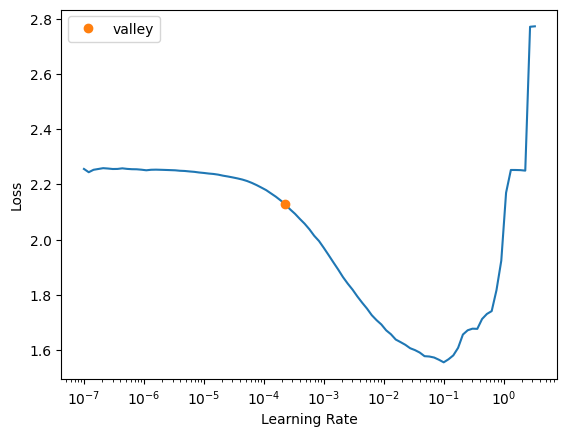

In [37]:
learner.lr_find()

In [38]:
learner.fit_one_cycle(9,5e-3,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.386277,0.520604,0.824870,02:03
1,0.263786,3.908937,0.591763,02:03
2,0.155624,0.687015,0.808677,02:03
3,0.104622,0.901816,0.817973,02:02
4,0.081955,0.077311,0.975210,02:02
5,0.060560,0.093030,0.969112,02:02
6,0.038695,0.041572,0.985606,02:03
7,0.028178,0.023552,0.992103,02:03
8,0.022384,0.019969,0.993902,02:03


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

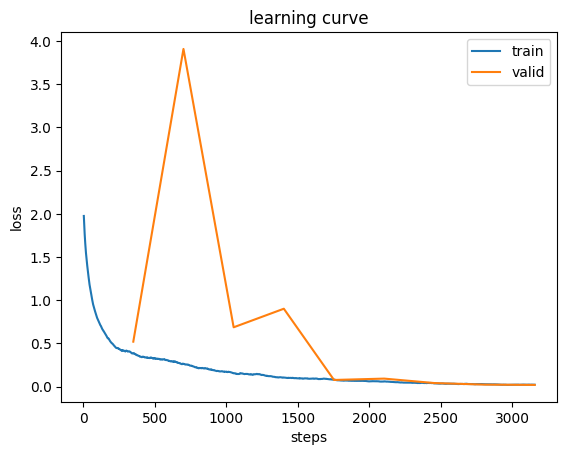

In [39]:
learner.recorder.plot_loss()

In [40]:
test_ds = PathMNIST(split='test', download=True, transform=val_tfms)

test_dl=DataLoader(test_ds,batch_size,shuffle=False,
                 num_workers=8,pin_memory=True)

In [41]:
test_loss, test_acc = learner.validate(dl=test_dl)
print(f'test_loss : {test_loss}, test_acc : {test_acc}')

test_loss : 0.37556061148643494, test_acc : 0.9121170043945312
